In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    xgb_available = False


In [3]:
df = pd.read_csv(r"/Users/dhruvroshan/Documents/GitHub/DMML-Dubai-UG-Group-2/Datasets/processed/tabular_data/brain_tumor_dataset.csv")
df.head()

df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Patient_ID           20000 non-null  int64  
 1   Age                  20000 non-null  int64  
 2   Gender               20000 non-null  object 
 3   Tumor_Type           20000 non-null  object 
 4   Tumor_Size           20000 non-null  float64
 5   Location             20000 non-null  object 
 6   Histology            20000 non-null  object 
 7   Stage                20000 non-null  object 
 8   Symptom_1            20000 non-null  object 
 9   Symptom_2            20000 non-null  object 
 10  Symptom_3            20000 non-null  object 
 11  Radiation_Treatment  20000 non-null  object 
 12  Surgery_Performed    20000 non-null  object 
 13  Chemotherapy         20000 non-null  object 
 14  Survival_Rate        20000 non-null  float64
 15  Tumor_Growth_Rate    20000 non-null 

Patient_ID             0
Age                    0
Gender                 0
Tumor_Type             0
Tumor_Size             0
Location               0
Histology              0
Stage                  0
Symptom_1              0
Symptom_2              0
Symptom_3              0
Radiation_Treatment    0
Surgery_Performed      0
Chemotherapy           0
Survival_Rate          0
Tumor_Growth_Rate      0
Family_History         0
MRI_Result             0
Follow_Up_Required     0
dtype: int64

In [ ]:

target_column = 'Survival_Rate'  
X = df.drop(columns=[target_column])
y = df[target_column]


for col in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}
if xgb_available:
    models["XGBoost"] = XGBRegressor(random_state=42, verbosity=0)

results = {}
for name, model in models.items():
    if name in ["SVR"]:  
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R2": r2}
    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

results_df = pd.DataFrame(results).T
display(results_df)


Linear Regression - MSE: 295.0940, R2: -0.0003
Ridge - MSE: 295.0940, R2: -0.0003
Lasso - MSE: 294.9333, R2: 0.0002
Random Forest - MSE: 300.8599, R2: -0.0199
SVR - MSE: 298.0409, R2: -0.0103
Gradient Boosting - MSE: 296.2180, R2: -0.0041
XGBoost - MSE: 323.7461, R2: -0.0974


,MSE,R2
Linear Regression,295.094041,-0.000323
Ridge,295.093974,-0.000323
Lasso,294.933254,0.000222
Random Forest,300.859862,-0.019869
SVR,298.040909,-0.010313
Gradient Boosting,296.218023,-0.004133
XGBoost,323.746073,-0.097449


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grids = {
    "Ridge": {"alpha": [0.01, 0.1, 1, 10, 100]},
    "Lasso": {"alpha": [0.01, 0.1, 1, 10, 100]},
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 5, 10, 20]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    }
}
if xgb_available:
    param_grids["XGBoost"] = {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    }

tuned_models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}
if xgb_available:
    tuned_models["XGBoost"] = XGBRegressor(random_state=42, verbosity=0)

tuned_results = {}

for name, model in tuned_models.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(
        model,
        param_grids[name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    if name == "SVR":
        grid.fit(X_train_scaled, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test_scaled)
    else:
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    tuned_results[name] = {
        "Best Params": grid.best_params_,
        "MSE": mse,
        "R2": r2
    }
    print(f"{name} best params: {grid.best_params_}")
    print(f"{name} - Tuned MSE: {mse:.4f}, R2: {r2:.4f}")

tuned_results_df = pd.DataFrame(tuned_results).T
display(tuned_results_df)

Tuning Ridge...
Ridge best params: {'alpha': 100}
Ridge - Tuned MSE: 295.0875, R2: -0.0003
Tuning Lasso...
Lasso best params: {'alpha': 1}
Lasso - Tuned MSE: 294.9333, R2: 0.0002
Tuning Random Forest...
Random Forest best params: {'max_depth': 5, 'n_estimators': 200}
Random Forest - Tuned MSE: 294.8697, R2: 0.0004
Tuning Gradient Boosting...
Gradient Boosting best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Gradient Boosting - Tuned MSE: 295.1948, R2: -0.0007
Tuning XGBoost...
XGBoost best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
XGBoost - Tuned MSE: 294.9573, R2: 0.0001


,Best Params,MSE,R2
Ridge,{'alpha': 100},295.087499,-0.000301
Lasso,{'alpha': 1},294.933254,0.000222
Random Forest,"{'max_depth': 5, 'n_estimators': 200}",294.869737,0.000437
Gradient Boosting,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",295.194826,-0.000665
XGBoost,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",294.957281,0.00014



 SelectKBest Linear Regression


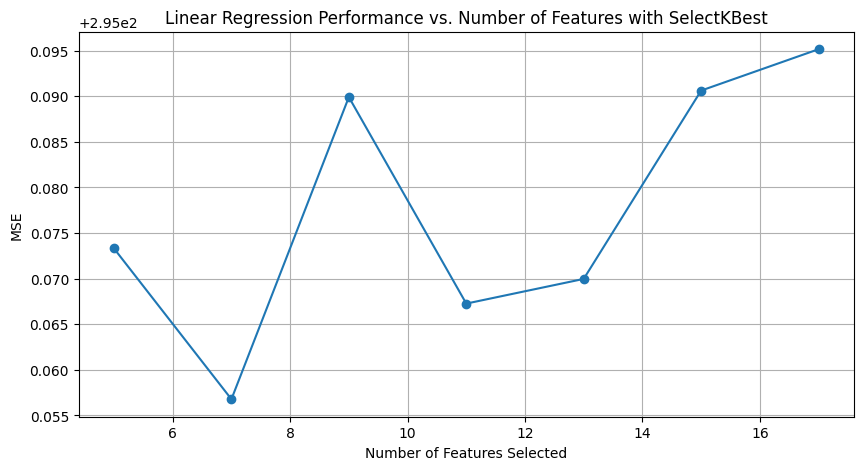

Best number of features = 7, Best MSE = 295.0568


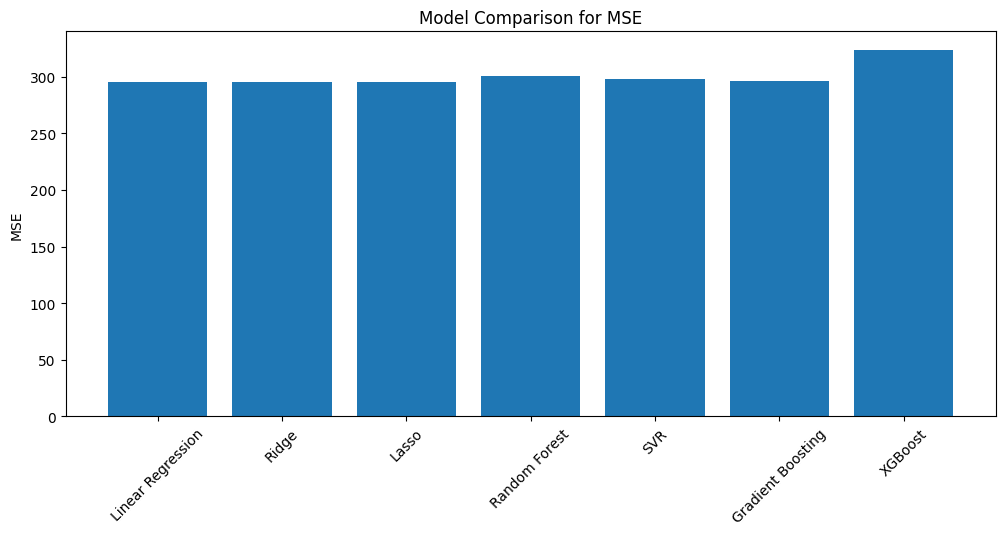

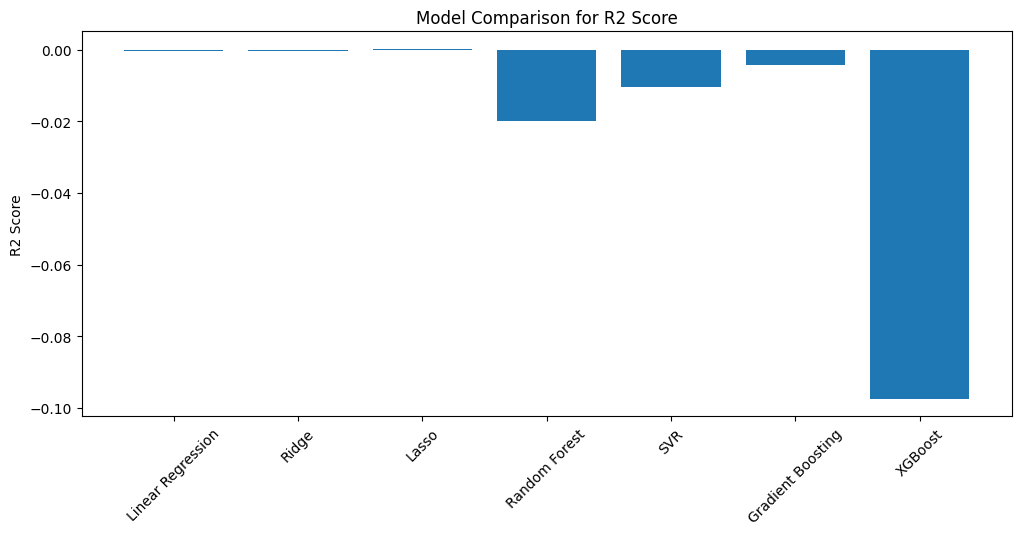


Best performing model: Lasso


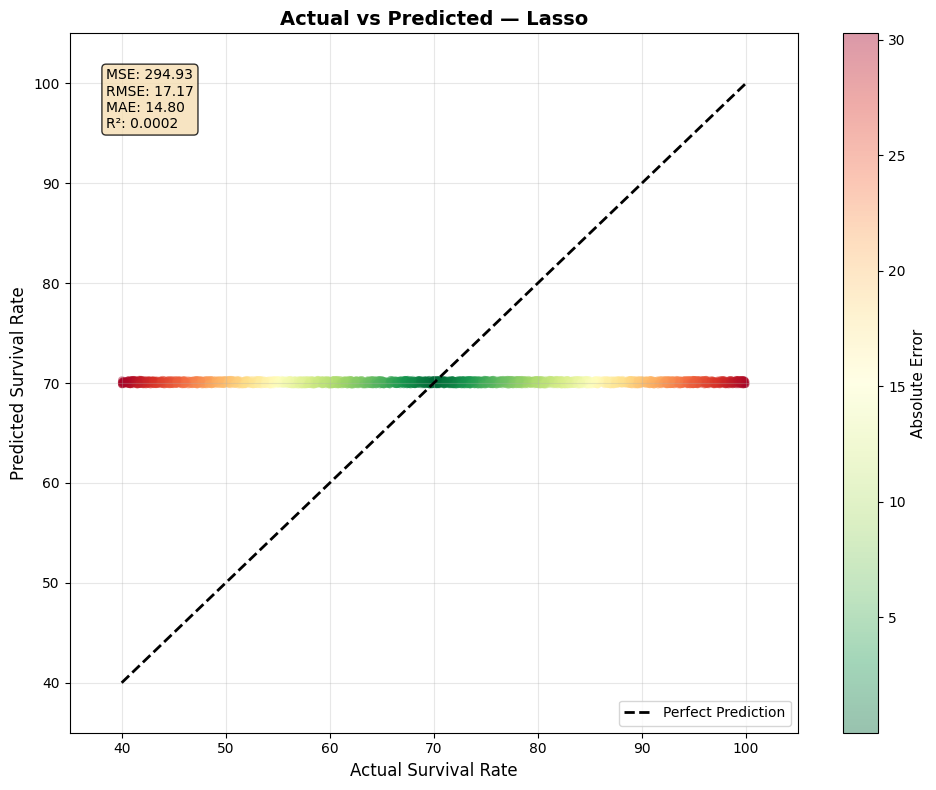

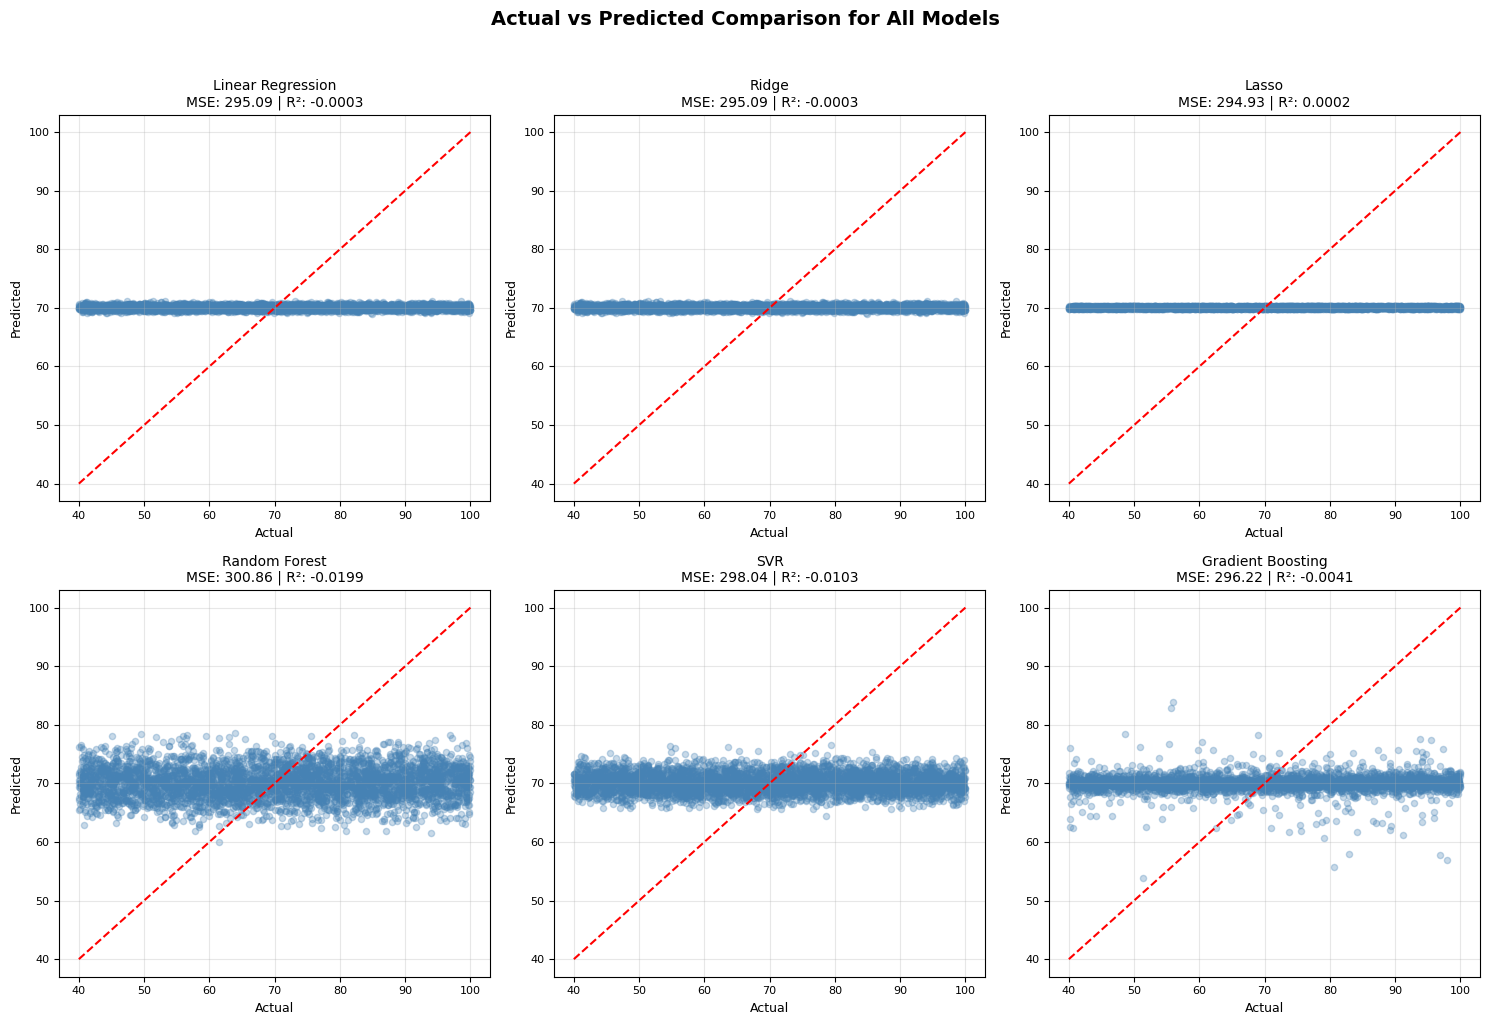

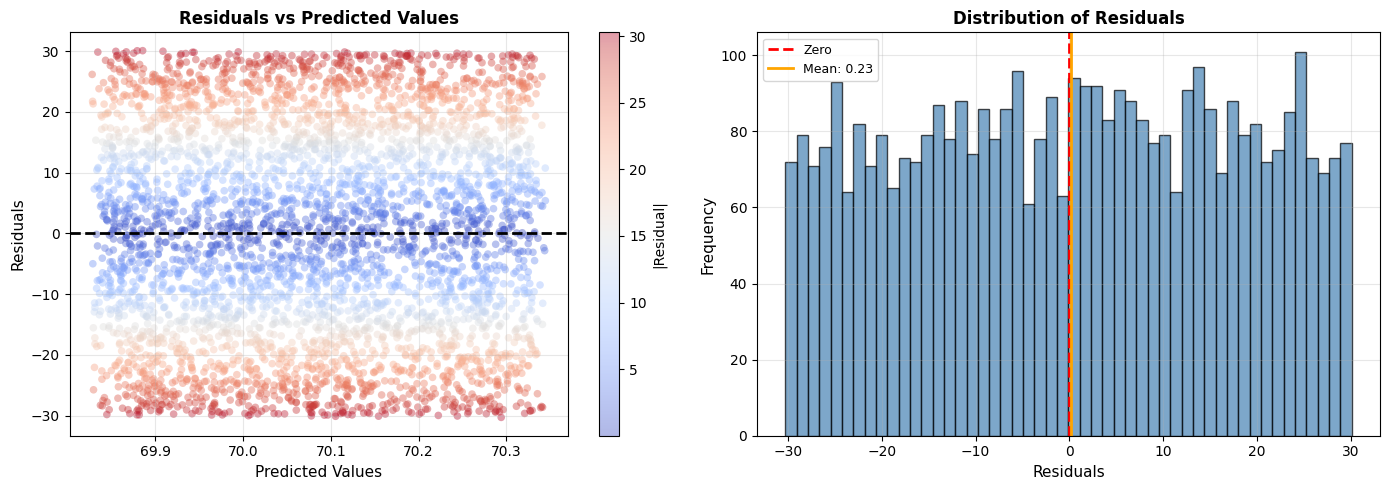

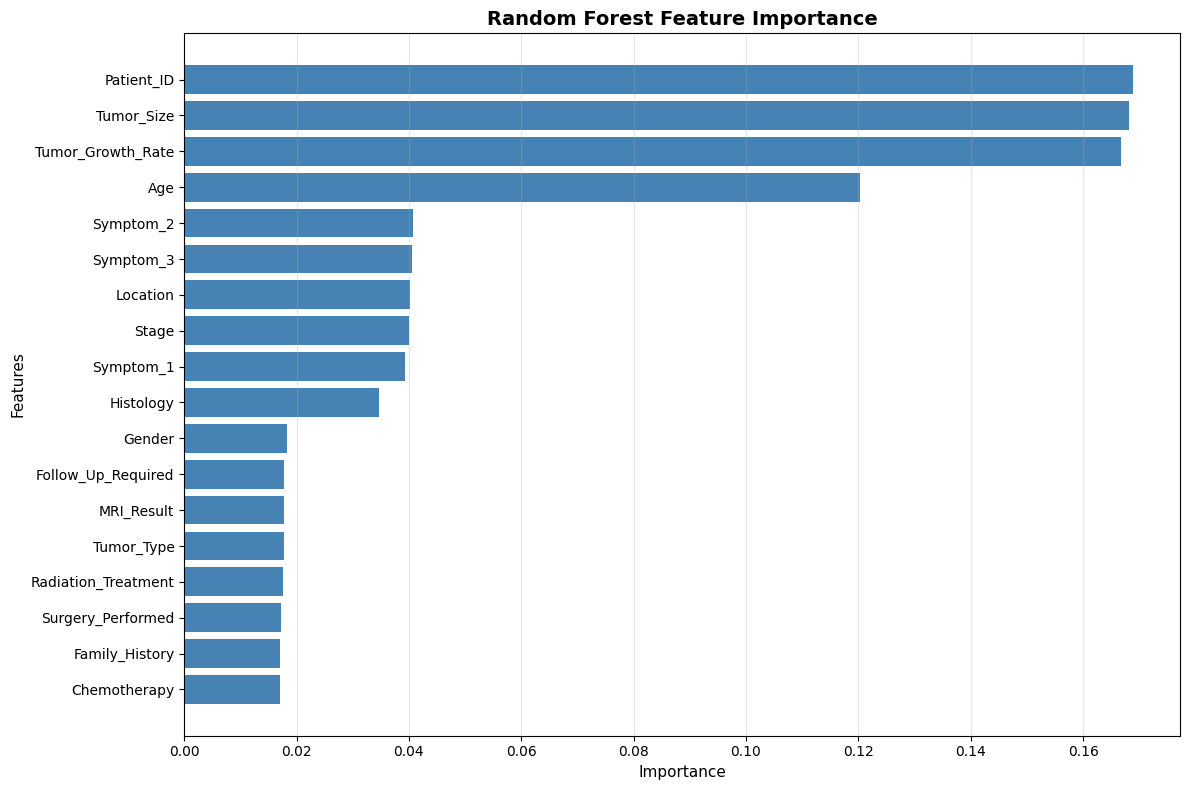

In [7]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


print("\n SelectKBest Linear Regression")

best_scores = []
feature_counts = range(5, X_train.shape[1] + 1, 2)

for k in feature_counts:
    selector = SelectKBest(f_regression, k=k)
    X_train_sel = selector.fit_transform(X_train, y_train)
    X_test_sel = selector.transform(X_test)
    
    lr = LinearRegression()
    lr.fit(X_train_sel, y_train)
    y_pred_sel = lr.predict(X_test_sel)
    
    mse_k = mean_squared_error(y_test, y_pred_sel)
    best_scores.append(mse_k)
    
plt.figure(figsize=(10,5))
plt.plot(feature_counts, best_scores, marker="o")
plt.xlabel("Number of Features Selected")
plt.ylabel("MSE")
plt.title("Linear Regression Performance vs. Number of Features with SelectKBest")
plt.grid(True)
plt.show()

best_k = feature_counts[np.argmin(best_scores)]
print(f"Best number of features = {best_k}, Best MSE = {min(best_scores):.4f}")


plt.figure(figsize=(12,5))
plt.bar(results_df.index, results_df["MSE"])
plt.xticks(rotation=45)
plt.ylabel("MSE")
plt.title("Model Comparison for MSE")
plt.show()

plt.figure(figsize=(12,5))
plt.bar(results_df.index, results_df["R2"])
plt.xticks(rotation=45)
plt.ylabel("R2 Score")
plt.title("Model Comparison for R2 Score")
plt.show()

best_model_name = list(results.keys())[np.argmin([v["MSE"] for v in results.values()])]
print(f"\nBest performing model: {best_model_name}")

best_model = models[best_model_name]
if best_model_name == "SVR":
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 8))


scatter = ax.scatter(y_test, y_pred_best, 
                     alpha=0.4, 
                     c=np.abs(y_test - y_pred_best),  
                     cmap='RdYlGn_r',  
                     s=30,
                     edgecolors='none')

min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Perfect Prediction')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Error', fontsize=11)

mse = mean_squared_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test - y_pred_best))

textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR²: {r2:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Actual Survival Rate", fontsize=12)
ax.set_ylabel("Predicted Survival Rate", fontsize=12)
ax.set_title(f"Actual vs Predicted — {best_model_name}", fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

ax.set_xlim([min_val - 5, max_val + 5])
ax.set_ylim([min_val - 5, max_val + 5])

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (name, model) in enumerate(models.items()):
    if idx >= 6:
        break
        
    if name == "SVR":
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    
    ax = axes[idx]
    ax.scatter(y_test, y_pred, alpha=0.3, s=20, c='steelblue')
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1.5)
    
    mse = results[name]["MSE"]
    r2 = results[name]["R2"]
    
    ax.set_title(f'{name}\nMSE: {mse:.2f} | R²: {r2:.4f}', fontsize=10)
    ax.set_xlabel("Actual", fontsize=9)
    ax.set_ylabel("Predicted", fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=8)

if len(models) < 6:
    for idx in range(len(models), 6):
        fig.delaxes(axes[idx])

plt.suptitle('Actual vs Predicted Comparison for All Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


residuals = y_test - y_pred_best

fig, axes = plt.subplots(1, 2, figsize=(14, 5))


ax1 = axes[0]
scatter1 = ax1.scatter(y_pred_best, residuals, alpha=0.4, c=np.abs(residuals), 
                       cmap='coolwarm', s=30, edgecolors='none')
ax1.axhline(0, color='black', linestyle='--', lw=2)
ax1.set_xlabel("Predicted Values", fontsize=11)
ax1.set_ylabel("Residuals", fontsize=11)
ax1.set_title("Residuals vs Predicted Values", fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('|Residual|', fontsize=10)


ax2 = axes[1]
ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax2.axvline(0, color='red', linestyle='--', lw=2, label='Zero')
ax2.axvline(residuals.mean(), color='orange', linestyle='-', lw=2, 
            label=f'Mean: {residuals.mean():.2f}')
ax2.set_xlabel("Residuals", fontsize=11)
ax2.set_ylabel("Frequency", fontsize=11)
ax2.set_title("Distribution of Residuals", fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if "Random Forest" in models:
    rf = models["Random Forest"]
    importances = rf.feature_importances_

    sorted_idx = np.argsort(importances)
    
    plt.figure(figsize=(12, 8))
    plt.barh(X.columns[sorted_idx], importances[sorted_idx], color='steelblue')
    plt.title("Random Forest Feature Importance", fontsize=14, fontweight='bold')
    plt.xlabel("Importance", fontsize=11)
    plt.ylabel("Features", fontsize=11)
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()